# Feature Extraction part 2

In [1]:
# Re-install pytables for hdf support (google colab has old & glitchy pytables)
#!pip uninstall -y tables
#!pip install tables

In [2]:
import pandas as pd
df = pd.read_hdf('fe1.h5')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227654 entries, 0 to 467481
Data columns (total 3 columns):
filename    227654 non-null object
text        227654 non-null object
lang        227654 non-null object
dtypes: object(3)
memory usage: 6.9+ MB


In [3]:
df.head()

,filename,text,lang
0,dataset/20191108/15/1491978796208217930.html,\n\n\n\n\n\n\n\n\n\n\n\nNewcastle United v Bou...,en
4,dataset/20191108/15/6359253557838878602.html,\n\n\n\n\n\n\n\n\n\n\n\nМинкомсвязь негативно ...,ru
6,dataset/20191108/15/8549607152500932485.html,\n\n\n\n\n\n\n\n\n\n\n\nTether Responds to Mar...,en
7,dataset/20191108/15/3752801377276103486.html,\n\n\n\n\n\n\n\n\n\n\n\nAnger over Las Vegas b...,en
10,dataset/20191108/15/5545714965965021212.html,\n\n\n\n\n\n\n\n\n\n\n\nAmerican Truck Simulat...,en


Предположительно все файлы имеют одинаковую структуру. В заголовке должны быть теги `<meta property="og:xxx" content="yyy"/>`. Проверим это...

In [4]:
import re
from tqdm import tqdm
from joblib import Parallel, delayed

regexps = (
    re.compile(r'<meta property="og:url" content="(.+)"/>'),
    re.compile(r'<meta property="og:site_name" content="(.+)"/>'),
    re.compile(r'<meta property="article:published_time" content="(.+)"/>'),
    re.compile(r'<meta property="og:title" content="(.+)"/>'),
    re.compile(r'<meta property="og:description" content="(.+)"/>'),
)

def process(fn):
  global regexps
  with open(fn, 'r') as f:
    data = f.read()
    df_row = []
    for r in regexps:
      m = r.search(data)
      df_row.append(m.group(1) if m else None)
  return df_row

df2 = pd.DataFrame(data=Parallel(n_jobs=-1, verbose=3)(delayed(process)(fn) for fn in tqdm(df['filename'].values)),
                   columns=['url', 'site', 'time', 'title', 'description'])
df2.info()

100%|██████████| 227654/227654 [00:08<00:00, 25345.06it/s]
[Parallel(n_jobs=-1)]: Done 226062 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 227654 out of 227654 | elapsed:    9.5s finished


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227654 entries, 0 to 227653
Data columns (total 5 columns):
url            227654 non-null object
site           227654 non-null object
time           227654 non-null object
title          227654 non-null object
description    227150 non-null object
dtypes: object(5)
memory usage: 8.7+ MB


In [5]:
df1 = df
df = df2

In [6]:
df.head()

,url,site,time,title,description
0,https://www.theguardian.com/football/2019/nov/...,the Guardian,2019-11-08T15:14:57+00:00,Newcastle United v Bournemouth: match preview,Newcastle finally found attacking rhythm last ...
1,https://newdaynews.ru/technology/676145.html,Новый День,2019-11-08T15:35:16+00:00,Минкомсвязь негативно оценила законопроект о б...,Минкомсвязь отказалась поддержать законопроект...
2,https://btcmanager.com/tether-market-manipulat...,BTC Manager,2019-11-08T15:00:10+00:00,Tether Responds to Market Manipulation Accusat...,"Tether, the most widely used stablecoin, has r..."
3,https://www.news24.com/World/News/anger-over-l...,News24,2019-11-08T15:31:00+00:00,Anger over Las Vegas ban on sleeping in streets,Faced with a growing number of homeless people...
4,https://www.destructoid.com/american-truck-sim...,Destructoid,2019-11-08T15:00:00+00:00,American Truck Simulator is free for the weekend,"Between Red Dead Redemption 2, Death Stranding..."


Посмотрим сколько файлов без тега `<meta property="og:url"`:

In [7]:
df[df['url'] == None].shape[0]

0

Все файлы с `url`.

Посмотрим сколько файлов без тегов:

In [8]:
for c in df.columns:
    print('%s: %d' % (c, df[df[c] == None].shape[0]))

url: 0
site: 0
time: 0
title: 0
description: 0


Теги есть во всех файлах. Структура файлов одинаковая.

## Разметка данных

Идея в том, что нужная категория вероятно содержится в url. Некторые url содержат слова `news`, `politics`, и др. Предлагается разметить данные по тегу `url` и затем скормить это в какую-нить ML-модель.

In [9]:
top_cat = 'News'
cats = {
    'Society': ('Politics', 'Elections', 'Legislation', 'Incidents', 'Crime'),
    'Economy': ('Markets', 'Finance', 'Business'),
    'Technology': ('Gadgets', 'Auto', 'Apps', 'Internet'),
    'Sports': ('Sport', 'E-Sport', 'ESport'),
    'Entertainment': ('Movies', 'Music', 'Games', 'Books', 'Arts'),
    'Science': ('Health', 'Biology', 'Physics', 'Genetics'),
}
other_cat = 'Other'
rev_cats = dict()
for cat in cats:
  for c in cats[cat]:
    rev_cats[c] = cat
  rev_cats[cat] = cat
top_cat, rev_cats

('News',
 {'Politics': 'Society',
  'Elections': 'Society',
  'Legislation': 'Society',
  'Incidents': 'Society',
  'Crime': 'Society',
  'Society': 'Society',
  'Markets': 'Economy',
  'Finance': 'Economy',
  'Business': 'Economy',
  'Economy': 'Economy',
  'Gadgets': 'Technology',
  'Auto': 'Technology',
  'Apps': 'Technology',
  'Internet': 'Technology',
  'Technology': 'Technology',
  'Sport': 'Sports',
  'E-Sport': 'Sports',
  'ESport': 'Sports',
  'Sports': 'Sports',
  'Movies': 'Entertainment',
  'Music': 'Entertainment',
  'Games': 'Entertainment',
  'Books': 'Entertainment',
  'Arts': 'Entertainment',
  'Entertainment': 'Entertainment',
  'Health': 'Science',
  'Biology': 'Science',
  'Physics': 'Science',
  'Genetics': 'Science',
  'Science': 'Science'})

In [10]:
all_cats = [top_cat] + list(rev_cats.keys())
all_cats

['News',
 'Politics',
 'Elections',
 'Legislation',
 'Incidents',
 'Crime',
 'Society',
 'Markets',
 'Finance',
 'Business',
 'Economy',
 'Gadgets',
 'Auto',
 'Apps',
 'Internet',
 'Technology',
 'Sport',
 'E-Sport',
 'ESport',
 'Sports',
 'Movies',
 'Music',
 'Games',
 'Books',
 'Arts',
 'Entertainment',
 'Health',
 'Biology',
 'Physics',
 'Genetics',
 'Science']

In [11]:
%%time
for cat in all_cats:
  df[cat.lower()] = df['url'].str.contains(cat, case=False, regex=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227654 entries, 0 to 227653
Data columns (total 36 columns):
url              227654 non-null object
site             227654 non-null object
time             227654 non-null object
title            227654 non-null object
description      227150 non-null object
news             227654 non-null bool
politics         227654 non-null bool
elections        227654 non-null bool
legislation      227654 non-null bool
incidents        227654 non-null bool
crime            227654 non-null bool
society          227654 non-null bool
markets          227654 non-null bool
finance          227654 non-null bool
business         227654 non-null bool
economy          227654 non-null bool
gadgets          227654 non-null bool
auto             227654 non-null bool
apps             227654 non-null bool
internet         227654 non-null bool
technology       227654 non-null bool
sport            227654 non-null bool
e-sport          227654 non-null bool
espor

In [12]:
for cat in all_cats:
  print(df[cat.lower()].value_counts())
  print()

False    114418
True     113236
Name: news, dtype: int64

False    222580
True       5074
Name: politics, dtype: int64

False    227405
True        249
Name: elections, dtype: int64

False    227635
True         19
Name: legislation, dtype: int64

False    226715
True        939
Name: incidents, dtype: int64

False    226701
True        953
Name: crime, dtype: int64

False    222621
True       5033
Name: society, dtype: int64

False    225455
True       2199
Name: markets, dtype: int64

False    227061
True        593
Name: finance, dtype: int64

False    218430
True       9224
Name: business, dtype: int64

False    226318
True       1336
Name: economy, dtype: int64

False    227493
True        161
Name: gadgets, dtype: int64

False    225665
True       1989
Name: auto, dtype: int64

False    227488
True        166
Name: apps, dtype: int64

False    227198
True        456
Name: internet, dtype: int64

False    226976
True        678
Name: technology, dtype: int64

False    212348
True 

In [13]:
import matplotlib.pyplot as plt
plt.show() # init

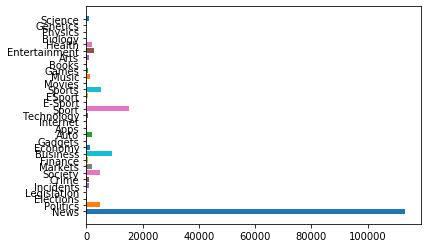

In [14]:
for cat in all_cats:
  plt.barh(cat, df[df[cat.lower()] == True].shape[0])
plt.show()

In [15]:
%%time
df.to_hdf('fe2.h5', 'fe2')
!ls -l fe2.h5

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['url', 'site', 'time', 'title', 'description']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


-rw-r--r-- 1 root root 245780728 Nov 23 05:43 fe2.h5
CPU times: user 704 ms, sys: 492 ms, total: 1.2 s
Wall time: 1.36 s


In [16]:
#%%time
#import pandas as pd
#df = pd.read_hdf('fe2.h5')
#df.info()

# EDA

In [15]:
df = df1
df[df2.columns] = df2

In [31]:
def get_cat_filters(lang):
    global df, rev_cats, top_cat, other_cat
    cat_filters = {cat: df[cat.lower()] == True for cat in set(rev_cats.values())}
    for cat in rev_cats:
        cat_filters[rev_cats[cat]] = cat_filters[rev_cats[cat]] | (df[cat.lower()] == True)
    for cat in cat_filters:
        cat_filters[cat] = cat_filters[cat] & (df[top_cat.lower()] == True)
    cat_filters[top_cat] = df[top_cat.lower()] == True
    cat_filters[other_cat] = df[top_cat.lower()] == True
    for cat in rev_cats:
        cat_filters[other_cat] = cat_filters[other_cat] & (df[cat.lower()] == False)
    for cat in cat_filters:
        cat_filters[cat] = cat_filters[cat] & (df['lang'] == lang)
    return cat_filters

In [29]:
def print_counts(lang):
    cat_filters = get_cat_filters(lang)
    cat_counts = {cat:0 for cat in cat_filters}
    for cat in cat_filters:
        cat_counts[cat] = df[cat_filters[cat]].shape[0]
    print(cat_counts)
    for cat in cat_counts:
        plt.barh(cat, cat_counts[cat])
    plt.title(lang)
    plt.show()

{'Entertainment': 558, 'Economy': 985, 'Sports': 1698, 'Technology': 408, 'Society': 1774, 'Science': 258, 'News': 25406, 'Other': 19886}


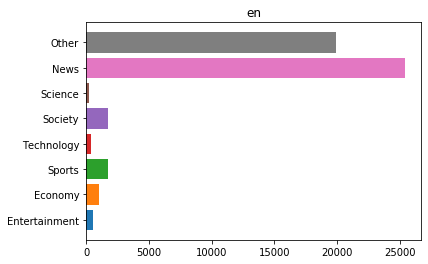

{'Entertainment': 586, 'Economy': 1126, 'Sports': 1686, 'Technology': 440, 'Society': 1697, 'Science': 259, 'News': 25896, 'Other': 20237}


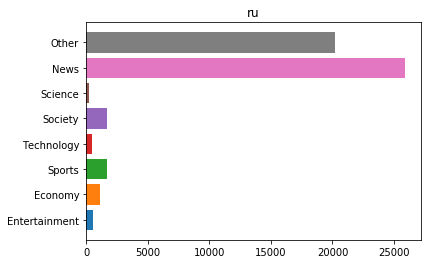

In [32]:
print_counts('en')
print_counts('ru')

In [33]:
%%time
df3 = df[get_cat_filters('en')[top_cat] | get_cat_filters('ru')[top_cat]]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51302 entries, 6 to 227650
Data columns (total 39 columns):
filename         51302 non-null object
text             51302 non-null object
lang             51302 non-null object
url              51302 non-null object
site             51302 non-null object
time             51302 non-null object
title            51302 non-null object
description      51236 non-null object
news             51302 non-null object
politics         51302 non-null object
elections        51302 non-null object
legislation      51302 non-null object
incidents        51302 non-null object
crime            51302 non-null object
society          51302 non-null object
markets          51302 non-null object
finance          51302 non-null object
business         51302 non-null object
economy          51302 non-null object
gadgets          51302 non-null object
auto             51302 non-null object
apps             51302 non-null object
internet         51302 non-null 

In [34]:
df3.to_hdf('fe3.h5', 'fe3')
!ls -l fe3.h5

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['filename', 'text', 'lang', 'url', 'site', 'time', 'title', 'description', 'news', 'politics', 'elections', 'legislation', 'incidents', 'crime', 'society', 'markets', 'finance', 'business', 'economy', 'gadgets', 'auto', 'apps', 'internet', 'technology', 'sport', 'e-sport', 'esport', 'sports', 'movies', 'music', 'games', 'books', 'arts', 'entertainment', 'health', 'biology', 'physics', 'genetics', 'science']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


-rw-r--r-- 1 root root 196841856 Nov 23 07:49 fe3.h5
